## Exploring Corona correlations with Weather

### Our research question
We want to find which weather variables correlate with number of COVID-19 cases in Denmark, and how well interventions by the danish government correlated with the severity of the pandemic, from March 2020 to February 2021

### Data sources and choice of variables

We were supplied with both weather and corona data in Denmark by our teacher.

We use variables from two additional datasets in this project:
- Oxford COVID-19 Government Response Tracker (https://github.com/OxCGRT/covid-policy-tracker/tree/master/data)
  - Policy indicators C1-C8, which record information on containment and closure policies 
  - Health system policy indicators H1-H8

- Data on COVID-19 (coronavirus) by Our World in Data (https://github.com/owid/covid-19-data/tree/master/public/data)
  - New confirmed cases of COVID-19 (7-day smoothed)



Importing the neccecary  libaries

In [ ]:
# Our imports
import json
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import statsmodels.api as sm
import folium
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests

# The file paths of our data are saved in the Config.py file
import Config

### Task 0: Data filtering and cleaning

- We check for NA values
- We filter the given corona data to only contain danish corona data
- We aggregate the danish weather data region and display the "min","mean","median","max" valeus for each variable


In [ ]:
# Loading in the data to pandas dataframes
corona_data = pd.read_csv(Config.corona_file_path, sep='\t')
weather_data = pd.read_csv(Config.weather_file_path)

In [ ]:
def data_report(df):
    # A helper function that takes in a data frame and reports the shape and missing values
    print("Shape:", df.shape)
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print(f"Are there any missing values in the dataset? {df.isna().any().any()}")
    print("=" * 10)
    
print("Report for corona data:")
data_report(corona_data)
print("Report for weather data:")
data_report(weather_data)

Report for corona data:
Shape: (1760, 3)
Number of rows: 1760
Number of columns: 3
Are there any missing values in the dataset? False
Report for weather data:
Shape: (20220, 9)
Number of rows: 20220
Number of columns: 9
Are there any missing values in the dataset? False


Currently the weather data contains data for countries other than Denmark, so we create a new dataframe that only contains the weather data for Denmark

In [ ]:
# Filter out weather data for Denmark
dk_weather_data = weather_data[weather_data['iso3166-2'].str.startswith("DK")]

# Print a report of the danish weather data only
print("Report for danish weather data:")
data_report(dk_weather_data)

# Display summary statistics by each of the 5 regions of Denmark
dk_weather_data.groupby(by = "iso3166-2").agg(["min","mean","median","max"])

Report for danish weather data:
Shape: (1845, 9)
Number of rows: 1845
Number of columns: 9
Are there any missing values in the dataset? False


RelativeHumiditySurface                                   \
                              min       mean     median        max   
iso3166-2                                                            
DK-81                   46.166826  81.055723  82.495994  98.183444   
DK-82                   49.033149  81.566104  83.703552  98.192610   
DK-83                   50.835916  80.914819  82.252746  96.980902   
DK-84                   50.049442  78.592708  79.835315  96.115837   
DK-85                   50.719733  79.364675  80.494326  96.581381   

          SolarRadiation                                            \
                     min          mean        median           max   
iso3166-2                                                            
DK-81           0.000000  6.998678e+06  4.519063e+06  2.407046e+07   
DK-82           0.005224  6.660075e+06  3.965236e+06  2.392633e+07   
DK-83           0.000000  6.768604e+06  4.503614e+06  2.403996e+07   
DK-84          85.014818  6.912021e+06  4.686215e+06  2.283164e+07   
DK-85         270.216521  7.163466e+06  4.990226e+06  2.349346e+07   

          Surfacepressure                ... Totalprecipitation            \
                      min          mean  ...             median       max   
iso3166-2                                ...                                
DK-81        2.342712e+06  2.424567e+06  ...           0.000765  0.018153   
DK-82        2.342463e+06  2.420853e+06  ...           0.000803  0.025882   
DK-83        2.346761e+06  2.424560e+06  ...           0.000773  0.024844   
DK-84        2.359255e+06  2.428423e+06  ...           0.000835  0.041373   
DK-85        2.355432e+06  2.428640e+06  ...           0.000696  0.026545   

          UVIndex                                  WindSpeed            \
              min       mean     median        max       min      mean   
iso3166-2                                                                
DK-81         0.0  14.137697   9.979405  44.536232  0.977651  4.789387   
DK-82         0.0  14.285644   9.993017  44.405486  0.804547  4.128445   
DK-83         0.0  15.077168  10.867238  43.914882  1.167244  4.548929   
DK-84         0.0  14.931567  11.106236  43.076212  0.839867  4.317130   
DK-85         0.0  15.076703  11.327366  43.986360  1.219587  4.478090   

                                
             median        max  
iso3166-2                       
DK-81      4.449917  12.426109  
DK-82      3.821016  11.173086  
DK-83      4.236949  12.495682  
DK-84      3.918726  10.487981  
DK-85      4.192292  11.374737  

[5 rows x 28 columns]

#### Merging weather and corona data to "df"

In [ ]:
# Loading Denmark's metadata
with open(Config.country_metadata_path, 'r') as f:
    country_metadata = json.load(f)

In [ ]:
# adding iso codes to corona data
region_map = {country_metadata["country_metadata"][i]["covid_region_code"]: 
country_metadata["country_metadata"][i]["iso3166-2_code"] 
for i in range(len(country_metadata["country_metadata"]))}

corona_data["region_code"] = corona_data["region_code"].map(region_map)


# selecting danish da
dk_weather_data = weather_data[weather_data['iso3166-2'].str.startswith("DK")]

#merge corona and weather datframes, by date and region
df = corona_data.merge(dk_weather_data, left_on = ["date", "region_code"], right_on = ["date", "iso3166-2"])

#drop redundant region columns
df = df.drop([ "region_code"], axis = 1)

### Estimating time from infection to hospitalization (days)
Infection to symptoms = 5 days (source: healthline.com/health/coronavirus-incubation-period)

Symptoms to hospitalization = 3-10,4 days (source: pubmed.ncbi.nlm.nih.gov/33080869/) Average: (3 + 10,4)/2 = 6,7 ~ 7 days


Total average infection to hospitalization time = 5 + (3 + 10,4)/2 = 11,7 ~ 12 days

In [ ]:
def offset():
    # Creating dataframe consisting of date, hospitalized, cases and region
    df_delta = df.copy()

    # Convert date to datetime
    df_delta['date'] = pd.to_datetime(df_delta['date'])
    df['date'] = pd.to_datetime(df['date'])


    #off set dates columns by 12 and 7
    df_delta['date_offset_12'] = df_delta['date'] + pd.DateOffset(days=12)
    df_delta['date_offset_7'] = df_delta['date'] + pd.DateOffset(days=7)

    # loading 7-day rolling mean covid-19 case data
    cases_df = pd.read_csv(Config.cases_path)

    # Wrangling for the columns we want
    cases_df = cases_df.loc[cases_df['iso_code'] == 'DNK'][['new_cases_smoothed','date']]
    cases_df['date'] = pd.to_datetime(cases_df['date']) # Convert date column to pandas date time format


    temp_merged = df_delta.merge(cases_df, left_on=['date_offset_7'], right_on=['date'])
    
    # Fixing names and removing duplicate columns
    temp_merged.drop(['date_y'] ,axis = 1, inplace=True)
    temp_merged.rename({'date_x':'date'}, axis = 1, inplace=True)


    return temp_merged

In [ ]:
df_merged = offset()

#### Merging external stringency index dataset

In [ ]:
# loading external dataset
# source: https://covidtracker.bsg.ox.ac.uk/ 
# data: https://github.com/OxCGRT/covid-policy-tracker/tree/master/data

# Load in the data
ex_df = pd.read_csv(Config.stringency_path)

# Choose only date, stringency index and it's components for Denmark
comp_list = ['C1_School closing',
        'C2_Workplace closing',
        'C3_Cancel public events',
        'C4_Restrictions on gatherings',
        'C5_Close public transport',
        'C6_Stay at home requirements',
        'C7_Restrictions on internal movement',
        'C8_International travel controls',
        'H2_Testing policy', 
        'H3_Contact tracing',
        'H4_Emergency investment in healthcare', 
        'H5_Investment in vaccines',
        'H6_Facial Coverings', 
        'H7_Vaccination policy',
        'H8_Protection of elderly people']
ex_df_dk = ex_df[ex_df['CountryCode'] == 'DNK'][comp_list+['Date', 'StringencyIndexForDisplay']]


# convert YYYYMMDD to unix timestamp and change name of date column
ex_df_dk['date'] = ex_df_dk['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

# convert time step of merged delta df to unix
df_merged['date'] = pd.to_datetime(df_merged['date'])

# Merge the new stringency index data onto our corona data
df_stringent = df_merged.merge(ex_df_dk, left_on= ['date'], right_on= ['date'])

# Fixing datetime format
df_stringent['date'] = pd.to_datetime(df_stringent['date'])

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Now that we have a processed data frame that contains the weather data for Denmark we can continue to the task of analysing and visualizing the data

### Task 1: Single variable analysis
Reporting key statistics for number of hospitalizations and temperature, for the different country regions, and in different levels of aggregation (daily, weekly, monthly).

In [ ]:
region_list = ["Region of Southern Denmark","Central Denmark Region","Region Zealand","North Denmark Region","Capital Region of Denmark"]
region_codes = ["DK-82","DK-82","DK-85","DK-81","DK-84"]

# Getting the columns we are interested in for the single variable weather analysis
Xs = ['Surfacepressure', 'TemperatureAboveGround', 'Totalprecipitation','UVIndex', 'WindSpeed']


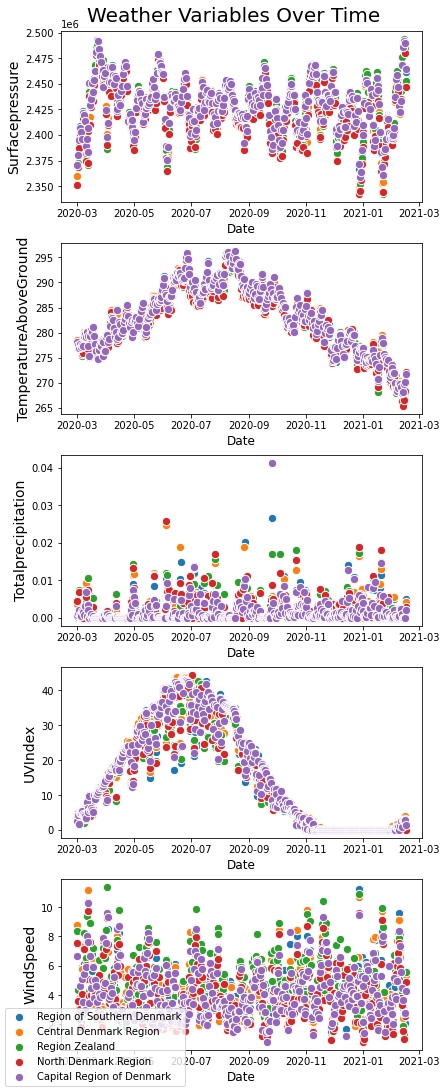

In [ ]:
# We are defining a function to plot a variable for each region in relation to time
def plot_variable_across_regions(ax, var):
    # Plotting temperature data from regions by dates
    for region in set(df_stringent['iso3166-2']):
        x = df_stringent.loc[df_stringent['iso3166-2'] == region]['date']
        y = df_stringent.loc[df_stringent['iso3166-2'] == region][var]

        # Add title and labels to plot
        #ax.set_title(f"{var} across regions", fontsize=22)
        ax.set_ylabel(f"{var}", fontsize=14)
        ax.set_xlabel("Date", fontsize=12)
        ax.scatter(x, y, s=70, edgecolors="w", label=region)

        #ax.set_xticklabels(df_stringent['date'][::293], rotation=45) # number of days / (xticks-1) = 1760/6 = 293

        #ax.xaxis.set_major_locator(mdates.MonthLocator())
        #ax.set_xticklabels(df_stringent['date'], rotation=45) # number of days / (xticks-1) = 1760/6 = 293

        # Add legend to plot
        # ax.legend(labels=region_list)


# Add legend to plot
# axes.legend(labels=region_list);

# Initialising plot
fig, axs = plt.subplots(5,1, figsize=(6,15))
# Adding some padding to 
fig.tight_layout(pad=2.0)

fig.suptitle("Weather Variables Over Time", fontsize=20, y=1)


for i, ax in enumerate(axs):
    plot_variable_across_regions(ax, Xs[i])

fig.legend(labels=region_list, loc='lower left',framealpha=0.8)


We see that the variables UVIndex and Totalprecipitation have skewed data and data that is euqal to 0. We will use this fact when doing multivariate regression in a later code cell.

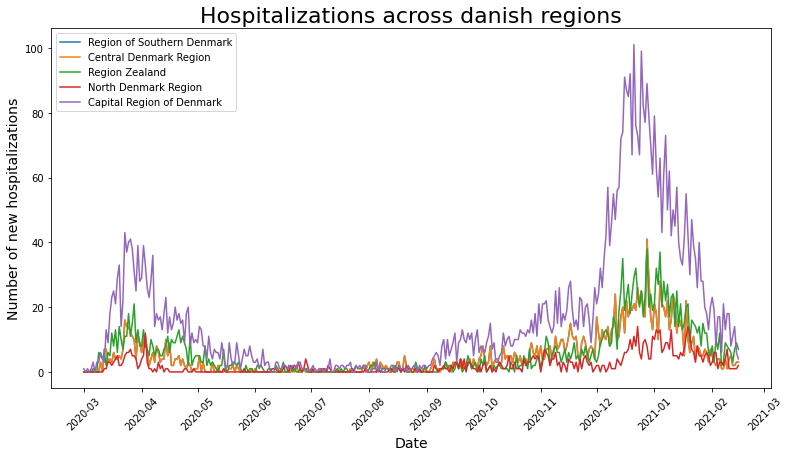

In [ ]:
# Initialising plot
fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0,0,1,1,])

# Plotting hospitalization data from regions by dates
for region in region_codes:
    x = df_stringent.loc[df_stringent['iso3166-2'] == region]['date']
    y = df_stringent.loc[df_stringent['iso3166-2'] == region]['hospitalized_addition']
    # Designate months as the x label
    axes.xaxis.set_major_locator(mdates.MonthLocator())

    # Rotate the x-values (dates) so they are at an angel
    plt.xticks(rotation=45)
    # Add title and labels to plot
    plt.title("Hospitalizations across danish regions", fontsize=22)
    plt.ylabel("Number of new hospitalizations", fontsize=14)
    plt.xlabel("Date", fontsize=14)
    axes.plot(x, y, label=region)

# Add legend to plot
#axes.legend(labels=region_list);
axes.legend(labels=region_list);

We plot the rolling average of hospitalized addition to get different levels of aggregation (daily, weekly, monthly)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


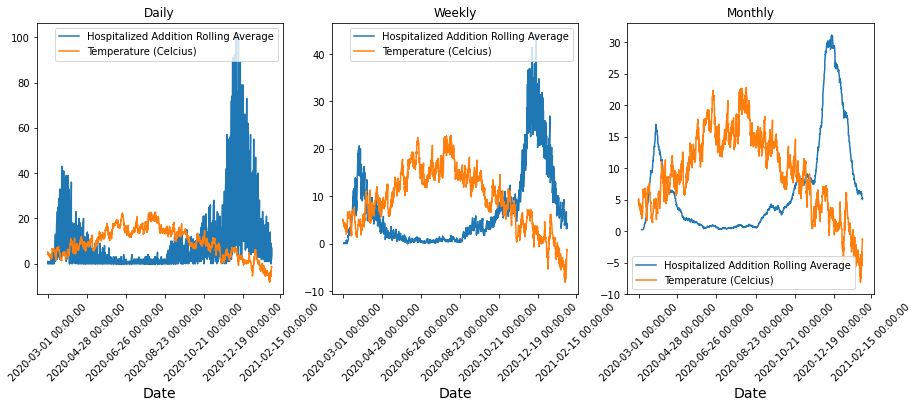

In [ ]:
# Rolling average 
fig, axs = plt.subplots(1,3, figsize=(15, 5))
rollinglst = [1, 7, 30]
rollinglst_labels = ["Daily", "Weekly", "Monthly"]
x = df_stringent['date']

for i, ax in enumerate(axs):
    ax.plot(x, df_stringent.rolling(rollinglst[i]).mean()['hospitalized_addition'], label="Hospitalized Addition Rolling Average")
    ax.plot(x, (df_stringent['TemperatureAboveGround']-273.5), label="Temperature (Celcius)");  
    # Designate months as the x label
    ax.set_xticklabels(x[::293], rotation=45) # number of days / (xticks-1) = 1760/6 = 293
    # ax.xaxis.set_major_locator(mdates.MonthLocator())

    # Add title
    ax.set_title(rollinglst_labels[i])
    # Add labels
    ax.set_xlabel("Date", fontsize=14)
    # ax.set_ylabel("Hospitalized Addition Rolling Average", fontsize=14)

    # Display legends
    ax.legend()

plt.show()


### Task 2: Associations

Merging the weather and corona data frames.

- We prepare our data before calculating correlations
- We calculate Pearson, Spearman, log-Pearson r-values and their corresponding p-values
- We use statsmodel to create a model using the holm-bonferroni method


In [ ]:
# cleaning weather data - checking whether there are any missing values
print(weather_data.isna().sum()) # --> there are no missing values in weather or corona data

# checking whether the sizes of weather and corona data frames are the same
print("Are the sizes of the two datasets different?", weather_data.shape != corona_data.shape)

# We need to remove weather data from before the 1st of March, so it matches with corona incidents
sliced_dk_weather_data = dk_weather_data.set_index(['date'])['2020-03-01':]

date                       0
iso3166-2                  0
RelativeHumiditySurface    0
SolarRadiation             0
Surfacepressure            0
TemperatureAboveGround     0
Totalprecipitation         0
UVIndex                    0
WindSpeed                  0
dtype: int64
Are the sizes of the two datasets different? True


In [ ]:
tests = ["Pearson r", "Spearman rank r", "log Pearson r"]

# Getting the columns we are interested in for the correlation-testing
Xs = ['Surfacepressure', 'TemperatureAboveGround', 'Totalprecipitation','UVIndex', 'WindSpeed']

# significance threshold 
alpha = 0.005

p_values = []

In [ ]:
# Initializing a dictionary, which will contain all the results from correlations
corr_res_dict = {
    'variable': [], 'method': [], 'correlation': [], 'p_value': [], 'is_significant': [],
}

# Define a helper function that adds values to the above dictionary in every test
def add_values(data):
    corr_res_dict['variable'].append(data[0])
    corr_res_dict['method'].append(data[1])
    corr_res_dict['correlation'].append(data[2])
    corr_res_dict['p_value'].append(data[3])
    corr_res_dict['is_significant'].append(data[4])

#### Pearson correlation

In [ ]:
# calculating pearson correlation coefficients (r)
#print(f"variable \n correlation \t pvalue \t is_significant\n")

for var in Xs:
    corr, pvalue = pearsonr(df_stringent["new_cases_smoothed"], sliced_dk_weather_data[var])
    p_values.append(pvalue)
    add_values([var, 'Pearson r', corr, pvalue, pvalue<alpha])
    #print(f"{var}\n{corr:.3F}\t{pvalue:.3F}\t{pvalue<alpha}\n")

#### Spearman rank correlation

In [ ]:
# calculating spearman correlation coefficients (r)
for var in Xs:
    corr, pvalue = spearmanr(df_stringent["new_cases_smoothed"], sliced_dk_weather_data[var])
    p_values.append(pvalue)
    add_values([var, 'Spearman r', corr, pvalue, pvalue<alpha])
    #print(f"{var}\nr={corr:.3F}\tp={pvalue:.3f}\t{pvalue<alpha}")
    #print("="*20+"\n")

#### Log-Pearson correlation

In [ ]:
# Calculating pearson log-transformed correlation coefficients
for var in Xs:
    corr, pvalue = pearsonr(np.log(df_stringent["new_cases_smoothed"]+1), sliced_dk_weather_data[var])
    #print(f"{var}, Correlation, P-value < Alpha\n{corr:.3F}\t{pvalue:.3f}\t{pvalue<alpha}\n")
    add_values([var, 'Log-Pearson', corr, pvalue, pvalue<alpha])
    #print("="*20+"\n")
    p_values.append(pvalue)

In [ ]:
# Turn our dictornary into a pandas dataframe for prettier visualizations
corr_res_df = pd.DataFrame(corr_res_dict)
corr_res_df

,variable,method,correlation,p_value,is_significant
0,Surfacepressure,Pearson r,-0.164185,4.204438e-12,True
1,TemperatureAboveGround,Pearson r,-0.416549,8.107592e-75,True
2,Totalprecipitation,Pearson r,0.048626,4.137818e-02,False
3,UVIndex,Pearson r,-0.630324,1.525263e-195,True
4,WindSpeed,Pearson r,0.045363,5.707859e-02,False
5,Surfacepressure,Spearman r,-0.074289,1.816609e-03,True
6,TemperatureAboveGround,Spearman r,-0.569798,4.652737e-152,True
7,Totalprecipitation,Spearman r,0.080801,6.914617e-04,True
8,UVIndex,Spearman r,-0.870849,0.000000e+00,True
9,WindSpeed,Spearman r,0.045617,5.569735e-02,False


#### Holm–Bonferroni corrections

In [ ]:
# holm-bonferroni correction
significant, p_holm_corrected, _, _ = multipletests(p_values, alpha=alpha, method = 'holm')

holm_correction_dict = {
    'variable': [], 'method': [], 'significant': []
}

# printing results
for i in range(len(significant)):
    #print("Test:", tests[i // len(Xs)])
    #print("Variable:", Xs[i % len(Xs)])
    #print(f"Significant: {significant[i]}\n")
    holm_correction_dict['variable'].append(Xs[i % len(Xs)])
    holm_correction_dict['method'].append(tests[i // len(Xs)])
    holm_correction_dict['significant'].append(significant[i])

In [ ]:
# Turn our holm_correction_dict dictionary into a pandas dataframe for easier readings
holm_correction_df = pd.DataFrame(holm_correction_dict)
holm_correction_df

,variable,method,significant
0,Surfacepressure,Pearson r,True
1,TemperatureAboveGround,Pearson r,True
2,Totalprecipitation,Pearson r,False
3,UVIndex,Pearson r,True
4,WindSpeed,Pearson r,False
5,Surfacepressure,Spearman rank r,False
6,TemperatureAboveGround,Spearman rank r,True
7,Totalprecipitation,Spearman rank r,True
8,UVIndex,Spearman rank r,True
9,WindSpeed,Spearman rank r,False


### Task 3: Map visualization

Use choropeths to visualize cases in your country

- Cases in country
- Population in country
- Cases/Population in country

Insert pretty pictures

Due to our data lacking the distinction between different regions, we use hospitalized addition that was given to us by Michele on learnIT.

In [ ]:
# to add population data, we create another dictionary from country metadata with iso codes and population
corona_data_by_region = df_stringent.groupby(by = "iso3166-2")["hospitalized_addition"].sum().reset_index()

# creating a map from regions' iso code to population
population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]:
country_metadata["country_metadata"][i]["population"] 
for i in range(len(country_metadata["country_metadata"]))}

# mapping from regions' iso code to population
corona_data_by_region["population"] = corona_data_by_region["iso3166-2"].map(population_map)

### Choropeth maps

In [ ]:
def make_map(name, cols, color, legend, data = corona_data_by_region):
    """ A function to make choropeth maps with only two layers """

    folium_map = folium.Map(location = [56, 10], zoom_start = 6)

    folium.Choropleth(
        key_on = "properties.iso_3166_2",
        fill_color = color,
        fill_opacity = 0.7,
        line_opactiy = 0.5,
        geo_data = Config.geo_json_path,

        name = name,
        data = data,
        columns = cols,
        legend_name = legend
    ).add_to(folium_map)

    folium.LayerControl().add_to(folium_map)

    return folium_map

#### Choropleth of hospitalized patients per region

In [ ]:
cases_map = make_map(
    name= "Cases", 
    cols = ["iso3166-2", 'hospitalized_addition'],
    color = 'OrRd',
    legend = "Hospitalized covid-19 patients pr. region in Denmark"
    )

cases_map

#### Choropleth of population per region

In [ ]:
pop_map = make_map(
    name= "Hospitalized per capita", 
    cols = ["iso3166-2", "population"],
    color = 'YlGn',
    legend = "Total population in region"
    )

pop_map

#### Choropleth of hospitalized per capita (per region)

In [ ]:
#adding hospitalized per capita column
corona_data_by_region['hospitalized_pc'] = corona_data_by_region['hospitalized_addition'] / corona_data_by_region['population']

In [ ]:
hosp_per_capita_map = make_map(
    name= "Hospitalized per capita", 
    cols = ["iso3166-2", "hospitalized_pc"],
    color = 'OrRd',
    legend = 'Hospitalized covid-19 patients pr. region in Denmark pr. capita'
    )

hosp_per_capita_map

### Task 4: Open question
- We do a multivariate regression to figure out which weather variable is doing the work
- We log transform skewed data from task 1
- We try a prediction on both total cases and cases per capita
- We cluster our standard errors at the region level

- We do a multiple regression containing government intervention data, to assess their effects on Covid-19

In [ ]:
# We add a constant to our dataframe that we are passing to multivariate regression, since sm.OLS expects one
#df_stringent = sm.add_constant(df_stringent)
df_stringent['const'] = 0
Xs.append("const")

,date,hospitalized_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,...,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H7_Vaccination policy,H8_Protection of elderly people,Date,StringencyIndexForDisplay,const
0,2020-03-01,1,DK-84,79.371362,3.383109e+06,2.370635e+06,278.214128,0.000764,2.595843,6.668466,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20200301,11.11,0
1,2020-03-01,0,DK-85,80.658130,3.376985e+06,2.370150e+06,278.261854,0.000779,2.994885,7.499609,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20200301,11.11,0
2,2020-03-01,0,DK-83,80.691986,3.601074e+06,2.360351e+06,278.601110,0.003793,4.295503,8.785296,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20200301,11.11,0
3,2020-03-01,0,DK-82,83.944243,4.346587e+06,2.351536e+06,277.945169,0.004593,3.984539,7.543797,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20200301,11.11,0
4,2020-03-01,0,DK-81,83.830573,4.183014e+06,2.351863e+06,277.817017,0.004858,3.922197,8.374069,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20200301,11.11,0


In [ ]:
# Regional Fixed Effects!
# we account for regional variation in the data by adding a "dummy" variable for each region

region_list = []

for region in set(df_stringent["iso3166-2"]):
    if region != "DK-84":
        df_stringent[region] = (df_stringent["iso3166-2"] == region).astype(int)
        region_list.append(region)
        Xs.append(region)


### Multivariate regressions for different variables

In [ ]:
# We are doing multiple multivariate regressions with different variables that are processed differently

# Initial multivariate regression
ols1 = sm.OLS(df_stringent["new_cases_smoothed"], df_stringent[Xs], hasconst=True).fit()

# Multivariate regression with all logged variables
# We remember to add an integer to every value in the columns, since log(0) is undefined
ols2 = sm.OLS(np.log(df_stringent["new_cases_smoothed"]+1), np.log(df_stringent[Xs]+15), hasconst=True).fit()

# Logging only select variables in our dataframe
log_lst = ['UVIndex', 'Totalprecipitation']
log_stringent_df = df_stringent.copy() # Copy our dataframe, as to not log on our original dataframe
for col in log_lst:
    log_stringent_df[col] = np.log(df_stringent[col] + 1) 
ols3 = sm.OLS(np.log(df_stringent["new_cases_smoothed"]+1), log_stringent_df[Xs], hasconst=True).fit()

# Per capita multivariate regression, and logged varialbes from before
pop_of_dk = 5.831 * 10**6 # Calculating the population of Denmark
df_stringent["new_cases_smoothed_pc"] = df_stringent["new_cases_smoothed"] / pop_of_dk
ols4 = sm.OLS(np.log(df_stringent["new_cases_smoothed_pc"]+1), log_stringent_df[Xs], hasconst=True).fit()

ols5 = sm.OLS(np.log(df_stringent['new_cases_smoothed']+1), df_stringent[Xs], hasconst=True).fit(cov_type='cluster', cov_kwds={'groups': df_stringent['iso3166-2']}, use_t=True)


# Print the r squared values for all fitted regressions
print(f"R-squared value for OLS1: {ols1.rsquared}")
print(f"R-squared value for OLS2: {ols2.rsquared}")
print(f"R-squared value for OLS3: {ols3.rsquared}")
print(f"R-squared value for OLS4: {ols4.rsquared}")
print(f"R-squared value for OLS5: {ols5.rsquared}")

R-squared value for OLS1: 0.41133920005992985
R-squared value for OLS2: 0.7675798372538398
R-squared value for OLS3: 0.7335175225189036
R-squared value for OLS4: 0.6066469095331566
R-squared value for OLS5: 0.7265784360304164


We see that the R-squared for OLS2 is the highest out of the 5 multivariate regressions.

### Multivariate regression for external data (stringency index components)

In [ ]:
# We do a multiple regression with the dataframe with external data (stringency index) and skewed dates, clustered by groups
# Note that the comp_list variable is defined in task 0
ols = sm.OLS(np.log(df_stringent["new_cases_smoothed"]+1), df_stringent[Xs+comp_list], hasconst=True).fit(use_t= True)
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     new_cases_smoothed   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     1135.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:57:49   Log-Likelihood:                -686.38
No. Observations:                1760   AIC:                             1421.
Df Residuals:                    1736   BIC:                             1552.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Surfacepressure                        1.201e-06   4.41e-07      2.720      0.007    3.35e-07    2.07e-06
TemperatureAboveGround                    0.0474      0.004     12.775      0.000       0.040       0.055
Totalprecipitation                      -21.6088      3.232     -6.686      0.000     -27.947     -15.270
UVIndex                                  -0.0352      0.002    -17.085      0.000      -0.039      -0.031
WindSpeed                                -0.0038      0.005     -0.719      0.472      -0.014       0.007
const                                   5.76e-13   8.67e-14      6.647      0.000    4.06e-13    7.46e-13
DK-85                                     0.0066      0.027      0.245      0.807      -0.047       0.060
DK-83                                     0.0315      0.027      1.157      0.248      -0.022       0.085
DK-81                                     0.0165      0.027      0.604      0.546      -0.037       0.070
DK-82                                     0.0256      0.027      0.931      0.352      -0.028       0.080
C1_School closing                        -0.3636      0.025    -14.594      0.000      -0.412      -0.315
C2_Workplace closing                     -0.3774      0.054     -6.963      0.000      -0.484      -0.271
C3_Cancel public events                   1.3269      0.056     23.870      0.000       1.218       1.436
C4_Restrictions on gatherings             0.4019      0.024     16.420      0.000       0.354       0.450
C5_Close public transport                -0.3375      0.065     -5.207      0.000      -0.465      -0.210
C6_Stay at home requirements              0.5860      0.056     10.530      0.000       0.477       0.695
C7_Restrictions on internal movement      0.2345      0.046      5.082      0.000       0.144       0.325
C8_International travel controls          0.0978      0.033      2.978      0.003       0.033       0.162
H2_Testing policy                        -0.4173      0.030    -13.998      0.000      -0.476      -0.359
H3_Contact tracing                      -12.9176      1.602     -8.065      0.000     -16.059      -9.776
H4_Emergency investment in healthcare  7.656e-09   1.75e-09      4.373      0.000    4.22e-09    1.11e-08
H5_Investment in vaccines             -3.537e-08   5.58e-08     -0.634      0.526   -1.45e-07     7.4e-08
H6_Facial Coverings                       0.9138      0.028     32.513      0.000       0.859       0.969
H7_Vaccination policy                    -0.2367      0.024     -9.890      0.000      -0.284      -0.190
H8_Protection of elderly people           0.3457      0.027     12.800      0.000       0.293       0.399
==============================================================================
Omnibus:                        7.09

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4792c742-55ce-4b84-98a0-1b3e971a7913' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>